In [1]:
! pip install -U chainer==2.0

Requirement already up-to-date: chainer==2.0 in /Users/KANI112094/.pyenv/versions/anaconda3-5.0.1/envs/py36/lib/python3.6/site-packages
Requirement already up-to-date: protobuf>=2.6.0 in /Users/KANI112094/.pyenv/versions/anaconda3-5.0.1/envs/py36/lib/python3.6/site-packages (from chainer==2.0)
Requirement already up-to-date: nose in /Users/KANI112094/.pyenv/versions/anaconda3-5.0.1/envs/py36/lib/python3.6/site-packages (from chainer==2.0)
Requirement already up-to-date: filelock in /Users/KANI112094/.pyenv/versions/anaconda3-5.0.1/envs/py36/lib/python3.6/site-packages (from chainer==2.0)
Requirement already up-to-date: six>=1.9.0 in /Users/KANI112094/.pyenv/versions/anaconda3-5.0.1/envs/py36/lib/python3.6/site-packages (from chainer==2.0)
    100% |████████████████████████████████| 4.7MB 214kB/s ta 0:00:01    27% |████████▉                       | 1.3MB 1.9MB/s eta 0:00:02
Requirement already up-to-date: setuptools in /Users/KANI112094/.pyenv/versions/anaconda3-5.0.1/envs/py36/lib/pyth

In [2]:
#ライブラリの読み込み
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import computational_graph
from chainer import serializers

/Users/KANI112094/.pyenv/versions/anaconda3-5.0.1/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
#データの読み込み
from sklearn.datasets import fetch_mldata
mnist=fetch_mldata("MNIST original",data_home=".")
X=mnist.data
y=mnist.target
#データの型を確認
print("X:{}".format(X.shape))
print("y:{}".format(y.shape))

X:(70000, 784)
y:(70000,)


In [4]:
#Chainerが処理できる数値型に変換
X=X.astype(np.float32)
y=y.astype(np.int32)
#画像の正規化
X/=255.

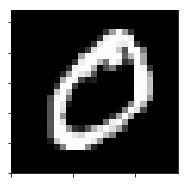

y:0


In [5]:
#データを画像として出力する関数を定義
def draw_digit(data):
    """数値の行列データを画像表示"""
    plt.figure(figsize=(3, 3))
    X, Y = np.meshgrid(range(28),range(28))
    Z = data.reshape(28, 28)
    Z = Z[::-1,:]
    plt.pcolor(X, Y, Z)
    plt.tick_params(labelbottom="off")
    plt.tick_params(labelleft="off")
    plt.gray()
    plt.show()
#データを画像として出力
draw_digit(X[0])
#正解ラベルを確認
print("y:%d"%y[0])

In [6]:
#データの分割
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,
                                test_size=0.3,random_state=0)

In [7]:
#ニューラルネットワークの定義

#chainerのChainクラスを継承
class MLP(chainer.Chain):
    #ニューラルネットワークの構造を定義
    def __init__(self):
        super(MLP,self).__init__()
        with self.init_scope():
            self.l1=L.Linear(784,900)
            self.l2=L.Linear(900,1000)
            self.l3=L.Linear(1000,500)
            self.l4=L.Linear(500,10)
        
    #ニューラルネットワークの計算規則を定義
    def __call__(self,X):
        h1=F.relu(self.l1(X))
        h2=F.relu(self.l2(h1))
        h3=F.relu(self.l3(h2))
        return self.l4(h3)

In [8]:
#分類機のインスタンスの生成
model=L.Classifier(MLP())
#GPUの使用の有無を指定(今回はCPUを想定しているため-1)
gpu=-1
#CuPyの使用の有無を指定
if gpu>0:
    #GPUを使用する場合はCuPyを使用
    xp=cuda.cupy
    cupy.cuda.Device(gpu).use()
    model.to_gpu()
else:
    #CPUを使用する場合はNumPyを使用
    xp=np

In [9]:
# # GPUを使用する場合は以下のコメントアウトを外して、データをCuPyの配列に変換

# # データをxpの32bit小数の型に変換
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
# # 数値をChainerが扱える型に変換
# X = X.astype(xp.float32)
# y = y.astype(xp.int32)

In [10]:
#Optimizerの定義
optimizer=chainer.optimizers.SGD()
optimizer.setup(model)

In [11]:
#ミニバッチに含まれるサンプル数を指定
batch_size=100
#epoch数を指定
n_epoch=20

In [12]:
#モジュールの読み込み
from chainer.datasets import tuple_dataset
from chainer import iterators,training
from chainer.training import extensions

In [13]:
#trainデータをTupleDataset型に変換しまとめ,trainを生成する
train=tuple_dataset.TupleDataset(X_train,y_train)
#trainとbatch_sizeを引き渡して、train_iterを生成する
train_iter=iterators.SerialIterator(train,batch_size=batch_size,
                                    shuffle=True)
#train_iterとoptimizerを引き渡して、updaterを生成する
updater=training.StandardUpdater(train_iter,optimizer,device=gpu)
#updaterとn_epochと新たなoutを引き渡し、trainerを生成する
trainer=training.Trainer(updater,(n_epoch,"epoch"),out="result")

In [14]:
#testを生成する
test=tuple_dataset.TupleDataset(X_test,y_test)
#test_iterを生成
test_iter=iterators.SerialIterator(test,batch_size=batch_size,
                                  shuffle=False,repeat=False)
#test_iterとmodelをEvaluatorに引き渡し、Evaluatorをtrainerに登録しておく
trainer.extend(extensions.Evaluator(test_iter,model))
#学習の状況を記録できるログファイルを作成する機能を追加
trainer.extend(extensions.LogReport())
#学習状況を逐一出力する機能を追加
#epoch:今何epoch目なのか？
#main/loss:訓練誤差(softmax_cross_entropyの出力)
#main/accuracy:訓練精度(正答率)
#validation/main/loss:検証誤差
#validation/main/accuracy:検証精度
trainer.extend(extensions.PrintReport(["epoch",
                                       "main/loss",
                                       "main/accuracy",
                                       "validation/main/loss",
                                    "validation/main/accuracy"]))
#trainとtestの精度のグラフを出力
trainer.extend(extensions.PlotReport(["main/accuracy",
                                      "validation/main/accuracy"],
                                    "epoch",
                                    file_name="accuracy.png"))
#trainとtestの損失関数のグラフを出力
trainer.extend(extensions.PlotReport(["main/loss",
                                     "validation/main/loss"],
                                    "epoch",
                                    file_name="loss.png"))
##epochごとの進捗状況をプログレスバーで報告する機能を追加
#trainer.extend(extensions.ProfressBar())

In [15]:
#学習の実行
trainer.run()

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy
1           1.37175     0.702224       0.588395              0.861143                  
2           0.451529    0.881408       0.374968              0.896238                  
3           0.341031    0.903327       0.320398              0.90819                   
4           0.296791    0.915959       0.287877              0.915524                  
5           0.267958    0.923918       0.264504              0.923048                  
6           0.245995    0.93           0.247555              0.927667                  
7           0.22749     0.934857       0.231136              0.933333                  
8           0.211508    0.939837       0.216467              0.936762                  
9           0.197539    0.944327       0.205839              0.939714                  
10          0.185068    0.94751        0.195019              0.942238                  
11          0.174009    0.950898  

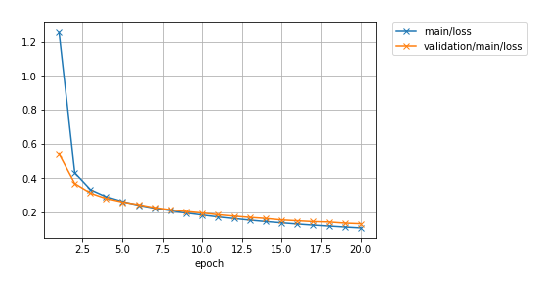

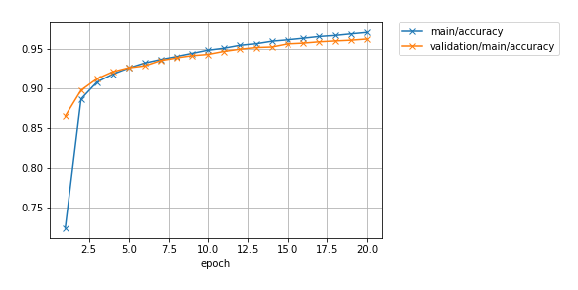

In [17]:
# ReportPlotによるグラフを出力する関数を定義
from pylab import box
def show_graph(src):
    img =  plt.imread(src)
    xpixels,ypixels = img.shape[0],img.shape[1]
    dpi = 100
    margin = 0.01
    figsize = (1 + margin) * ypixels / dpi, (1 + margin) * xpixels / dpi

    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
    ax.tick_params(labelbottom="off",bottom="off")
    ax.tick_params(labelleft="off",left="off")

    ax.imshow(img, interpolation='none')
    box("off")
    plt.show()
#誤差と精度のグラフを描画
show_graph('result/loss.png')
show_graph('result/accuracy.png')

In [1]:
# モデルを利用して予測をする関数を定義
def predict(model, X):
    # データ数が1の場合は、バッチサイズ分の次元を追加
    if len(X.shape) == 1:  
        pred = model.predictor(X[None, ...]).data.argmax()
    # データ数が2以上の場合はそのまま
    else:  
        pred = model.predictor(X).data.argmax(axis=1)
    return pred

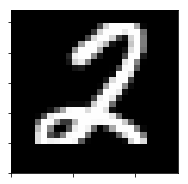

In [19]:
#indexを指定し任意の画像を出力
index=123
draw_digit(X_test[index])

In [20]:
#予測を行い答え合わせをする
pred=predict(model,X_test[index])
ans=y_test[index]

print("predict:",pred)
print("answer:",ans)

if pred==ans:
    print("正解です。")
else:
    print("不正解です。")

predict: 7
answer: 2
不正解です。


In [21]:
#間違いの傾向を評価するために、混同行列を出力
from sklearn.metrics import confusion_matrix as cm
result=predict(model,X_test)
cm(y_test,result)

array([[  21,    0,    0,    1,  249,    0,    4, 1727,    5,    1],
       [   0,    0,    0,   77,  351,   36,  123, 1745,   10,   70],
       [  10,    0,    0,    5,  455,    5,    7, 1539,   18,    6],
       [  10,    2,    1,    7, 1134,    1,   11,  846,    1,   69],
       [  10,    0,    1,   20,  299,    1,   73, 1648,    3,   23],
       [  14,    2,    0,    2,  739,    9,   34, 1105,    2,   13],
       [   8,    1,    1,  146,  630,    8,   24, 1248,    5,    7],
       [  12,    2,    0,    0,   60,    1,  105, 1930,    0,   81],
       [   8,    0,    0,   10,  447,    3,   28, 1565,    1,   31],
       [  19,    1,    0,   17,  189,    4,  185, 1631,    0,   47]])

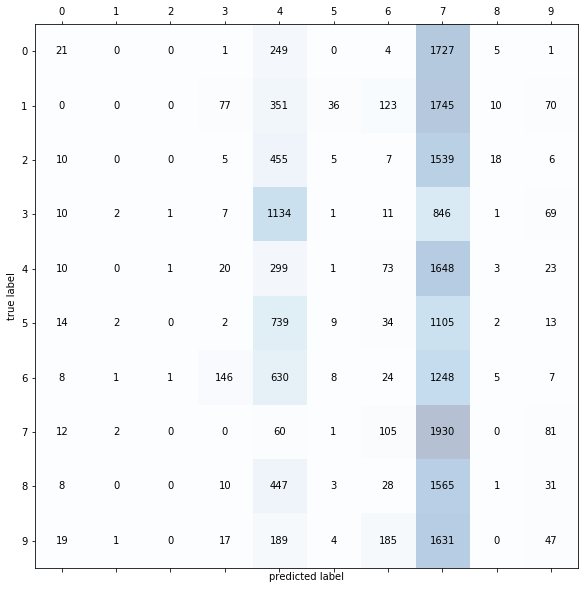

In [22]:
# 混同行列をグラフで出力する関数を定義
def plot_cm(y_true, y_pred):
    confmat = cm(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    plt.xticks(xp.arange(0, 10, 1)) # x軸の目盛りを指定
    plt.yticks(xp.arange(0, 10, 1)) # y軸の目盛りを指定
    plt.xlabel('predicted label')
    plt.ylabel('true label')
    plt.show()
#混同行列をグラフで出力
plot_cm(y_test,result)

In [23]:
#性能指標を一通り出力
from sklearn import metrics
print("accuracy:%.3f"%metrics.accuracy_score(y_test,result))
print("recall:%.3f"%metrics.recall_score(y_test,result,
                                         average="macro"))
print("precision:%.3f"%metrics.precision_score(y_test,result,
                                               average="macro"))
print("f1_score:%.3f"%metrics.f1_score(y_test,result,
                                       average="macro"))

accuracy:0.111
recall:0.108
precision:0.074
f1_score:0.041


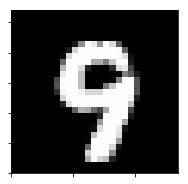

予測: 7
正解: 9


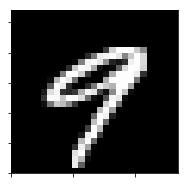

予測: 7
正解: 9


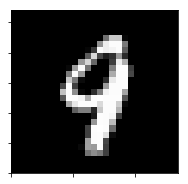

予測: 7
正解: 9


In [24]:
#正解が4か9のサンプルで予想が外れたものを表示(3つだけ)
count=0
for i in range(len(y_test)):
    ans=y_test[i]
    pred=predict(model,X_test[i])
    
    #asnが4でも9でもなかったら、for文の先頭に戻る(次の繰り返しに入る)
    if ans!=4 and ans!=9:
        continue
    
    if ans!=pred:
        count+=1
        draw_digit(X_test[i])
        print("予測:",pred)
        print("正解:",ans)
    
    #countが3になったら繰り返しを終了
    if count==3:
        break

In [15]:
#モデルの保存
#(ファイル名,保存したいモデルの変数名)
serializers.save_npz("mnist.npz",model)
#モデルの読み込み
#(ファイル名,読み込みたいモデルに与える変数名)
#時間のかかるrunをしなくても
serializers.load_npz('mnist.npz', model)

In [16]:
model